# End to End Matching Baseline

## Boilerplate

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from importlib import reload
import logging
reload(logging)
logging.basicConfig(format='%(asctime)s %(levelname)s:%(message)s', level=logging.INFO, datefmt='%H:%M:%S')

In [3]:
import sys

sys.path.insert(0, '..')

In [4]:
import entity_embed

In [5]:
import torch
import numpy as np

random_seed = 42
torch.manual_seed(random_seed)
np.random.seed(random_seed)

## Loading Test Data

In [6]:
from entity_embed.benchmarks import AmazonGoogleBenchmark

benchmark = AmazonGoogleBenchmark(data_dir_path="data/")
benchmark

13:24:41 INFO:Extracting Amazon-Google...
13:24:41 INFO:Reading Amazon-Google record_dict...
13:24:41 INFO:Reading Amazon-Google train.csv...
13:24:41 INFO:Reading Amazon-Google valid.csv...
13:24:41 INFO:Reading Amazon-Google test.csv...


<AmazonGoogleBenchmark> from http://pages.cs.wisc.edu/~anhai/data1/deepmatcher_data/Structured/Amazon-Google/amazon_google_exp_data.zip

In [7]:
record_dict = benchmark.record_dict
train_record_dict = benchmark.train_record_dict
valid_record_dict = benchmark.valid_record_dict
test_record_dict = benchmark.test_record_dict
train_pos_pair_set = benchmark.train_pos_pair_set
valid_pos_pair_set = benchmark.valid_pos_pair_set
test_pos_pair_set = benchmark.test_pos_pair_set
train_found_pair_set = benchmark.train_pos_pair_set | benchmark.train_neg_pair_set
valid_found_pair_set = benchmark.valid_pos_pair_set | benchmark.valid_neg_pair_set
test_found_pair_set = benchmark.test_pos_pair_set | benchmark.test_neg_pair_set

## Preprocess

In [8]:
field_list = ['title', 'manufacturer', 'price']

In [9]:
import unidecode
import itertools
from entity_embed import default_tokenizer

def clean_str(s):
    max_tokens = 100
    max_chars = 1000
    s = unidecode.unidecode(s).lower().strip()
    s_tokens = default_tokenizer(s)[:max_tokens]
    return ' '.join(s_tokens)[:max_chars]

for record in record_dict.values():
    for field in field_list:
        record[field] = clean_str(record[field])

## Matching: Compare

Make a dataframe `df` with all records (train, valid, test) to add additional features:

In [10]:
record_dict = {**train_record_dict, **valid_record_dict, **test_record_dict}

In [11]:
import pandas as pd

df = pd.DataFrame.from_dict(record_dict, orient='index')
df = df.drop(columns='id')

In [12]:
df['all'] = df.agg('{0[title]} - {0[manufacturer]} - {0[price]}'.format, axis=1)
df['price'] = pd.to_numeric(df['price'].str.replace(' ', ''), errors='coerce')
df.head(3)

,title,manufacturer,price,__source,cluster,all
465,adobe creative suite cs3 web standard upgrade ...,adobe,399.00,left,50,adobe creative suite cs3 web standard upgrade ...
1789,adobe cs3 production premium upgrade,,822.99,right,364,adobe cs3 production premium upgrade - - 822 ...
204,cisco ios enterprise services complete package...,cisco systems enterprise,NaN,left,1062,cisco ios enterprise services complete package...


Replace all `record_dict`s (train, valid, test) to add additional features:

In [13]:
train_record_dict = df.loc[train_record_dict.keys()].to_dict(orient='index')
valid_record_dict = df.loc[valid_record_dict.keys()].to_dict(orient='index')
test_record_dict = df.loc[test_record_dict.keys()].to_dict(orient='index')

del df

In [14]:
import textdistance as td
import math

def token_ops(func):
    def new_func(x, y):
        return func(x.split(), y.split())    
    return new_func

def empty_str(x, y):
    return int(not x or not y)

def empty_num(x, y):
    return int(not x or not y or math.isnan(x) or math.isnan(y))

def zero_if_empty(x):
    if not x or math.isnan(x):
        return 0
    else:
        return x

def abs_diff(x, y):
    return abs(zero_if_empty(x) - zero_if_empty(y))

def abs_diff_log10(x, y, min_val=math.log10(1e-5)):
    diff = abs_diff(x, y)
    if diff > 0:
        return max(math.log10(diff), min_val)
    else:
        return min_val

SIM_FUNC_DICT = {
    ("all", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("all", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("all", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("all", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("manufacturer", "empty_str"): empty_str,
    ("manufacturer", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("manufacturer", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("manufacturer", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("manufacturer", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("title", "jaccard"): token_ops(td.jaccard.normalized_similarity),
    ("title", "overlap"): token_ops(td.overlap.normalized_similarity),
    ("title", "damerau_levenshtein"): td.damerau_levenshtein.normalized_similarity,
    ("title", "jaro_winkler"): td.jaro_winkler.normalized_similarity,
    ("price", "empty_num"): empty_num,
    ("price", "abs_diff"): abs_diff,
    ("price", "abs_diff_log10"): abs_diff_log10,
}

def record_sim_func(record_pair):
    record_left, record_right = record_pair
    feature_dict = {}
    
    for (field, sim_func_name), sim_func in SIM_FUNC_DICT.items():
        sim = sim_func(record_left[field], record_right[field])
        feature_dict[f"{field}_{sim_func_name}"] = sim
    
    return feature_dict

In [15]:
%%time

pair = next(iter(test_pos_pair_set))
id_left, id_right = pair
feature_dict = record_sim_func((test_record_dict[id_left], test_record_dict[id_right]))

# display(test_record_dict[id_left], test_record_dict[id_right])
feature_dict

CPU times: user 1.35 ms, sys: 0 ns, total: 1.35 ms
Wall time: 1.11 ms


{'all_jaccard': 0.65,
 'all_overlap': 0.8666666666666667,
 'all_damerau_levenshtein': 0.7254901960784313,
 'all_jaro_winkler': 0.7564400305576777,
 'manufacturer_empty_str': 0,
 'manufacturer_jaccard': 1.0,
 'manufacturer_overlap': 1.0,
 'manufacturer_damerau_levenshtein': 1.0,
 'manufacturer_jaro_winkler': 1.0,
 'title_jaccard': 0.625,
 'title_overlap': 1.0,
 'title_damerau_levenshtein': 0.5737704918032787,
 'title_jaro_winkler': 0.7055425448868071,
 'price_empty_num': 0,
 'price_abs_diff': 10.08999999999999,
 'price_abs_diff_log10': 1.00389116623691}

In [16]:
from collections import defaultdict
import multiprocessing
from tqdm.auto import tqdm

def compare_pairs(record_dict, found_pair_set):
    all_feature_dict = defaultdict(list)
    chunksize = 100
    tasks = (
        (record_dict[id_left], record_dict[id_right])
        for (id_left, id_right)
        in found_pair_set
    )

    with multiprocessing.Pool() as pool:
        for feature_dict in tqdm(
            pool.imap(record_sim_func, tasks, chunksize=chunksize),
            total=len(found_pair_set)
        ):
            for feature, val in feature_dict.items():
                all_feature_dict[feature].append(val)

        pool.close()
        pool.join()
    
    return pd.DataFrame(all_feature_dict, index=pd.MultiIndex.from_tuples(found_pair_set))

In [17]:
%%time

train_feature_df = compare_pairs(train_record_dict, train_found_pair_set)
assert len(train_feature_df) == len(train_found_pair_set)
len(train_found_pair_set)

  0%|          | 0/6874 [00:00<?, ?it/s]

CPU times: user 241 ms, sys: 89.1 ms, total: 330 ms
Wall time: 459 ms


6874

In [18]:
%%time

valid_feature_df = compare_pairs(valid_record_dict, valid_found_pair_set)
assert len(valid_feature_df) == len(valid_found_pair_set)
len(valid_found_pair_set)

  0%|          | 0/2293 [00:00<?, ?it/s]

CPU times: user 88.5 ms, sys: 75.7 ms, total: 164 ms
Wall time: 218 ms


2293

In [19]:
%%time

test_feature_df = compare_pairs(test_record_dict, test_found_pair_set)
assert len(test_feature_df) == len(test_found_pair_set)
len(test_found_pair_set)

  0%|          | 0/2293 [00:00<?, ?it/s]

CPU times: user 70.8 ms, sys: 79.1 ms, total: 150 ms
Wall time: 215 ms


2293

## Matching: Compare - TFIDF Feature

In [20]:
from sklearn.feature_extraction.text import TfidfVectorizer

def get_tfidf_vectorizer(train_record_dict, valid_record_dict, field='all'):
    tfidf_vectorizer = TfidfVectorizer(
        analyzer='char',
        ngram_range=(2,4),
        min_df=2
    )
    train_valid_record_dict = {**train_record_dict, **valid_record_dict}
    tfidf_vectorizer.fit(record[field] for record in train_valid_record_dict.values())
    return tfidf_vectorizer

tfidf_vectorizer = get_tfidf_vectorizer(train_record_dict, valid_record_dict)
tfidf_vectorizer

TfidfVectorizer(analyzer='char', min_df=2, ngram_range=(2, 4))

In [21]:
import numpy as np

def add_tfidf_feature(tfidf_vectorizer, feature_df, record_dict, found_pair_set, field='all'):
    tfidf_matrix = tfidf_vectorizer.transform(record[field] for record in record_dict.values())

    id_to_idx = {id_: idx for idx, id_ in enumerate(record_dict.keys())}
    left_idx = [id_to_idx[left_id] for left_id, __ in found_pair_set]
    right_idx = [id_to_idx[right_id] for __, right_id in found_pair_set]
    tfidf_sim = tfidf_matrix[left_idx].multiply(tfidf_matrix[right_idx]).sum(axis=1)

    feature_df[f'{field}_tfidf'] = tfidf_sim

In [22]:
%%time

add_tfidf_feature(tfidf_vectorizer, train_feature_df, train_record_dict, train_found_pair_set)

CPU times: user 274 ms, sys: 4.25 ms, total: 278 ms
Wall time: 278 ms


In [23]:
%%time

add_tfidf_feature(tfidf_vectorizer, valid_feature_df, valid_record_dict, valid_found_pair_set)

CPU times: user 156 ms, sys: 3.13 ms, total: 159 ms
Wall time: 158 ms


In [24]:
%%time

add_tfidf_feature(tfidf_vectorizer, test_feature_df, test_record_dict, test_found_pair_set)

CPU times: user 156 ms, sys: 0 ns, total: 156 ms
Wall time: 156 ms


## Matching: Classify

In [25]:
train_valid_feature_df = pd.concat([train_feature_df, valid_feature_df])
train_valid_feature_df.head(3)

,,all_jaccard,all_overlap,all_damerau_levenshtein,all_jaro_winkler,manufacturer_empty_str,manufacturer_jaccard,manufacturer_overlap,manufacturer_damerau_levenshtein,manufacturer_jaro_winkler,title_jaccard,title_overlap,title_damerau_levenshtein,title_jaro_winkler,price_empty_num,price_abs_diff,price_abs_diff_log10,all_tfidf
465,1789,0.300000,0.6000,0.380282,0.677204,1,0.0,0.0,0.0,0.0,0.250000,0.600000,0.339623,0.677568,0,423.99,2.627356,0.301006
204,1376,0.375000,0.5625,0.336957,0.677550,1,0.0,0.0,0.0,0.0,0.437500,0.636364,0.409091,0.737375,1,2068.26,3.315605,0.478299
551,1420,0.321429,0.5000,0.470588,0.669510,1,0.0,0.0,0.0,0.0,0.238095,0.416667,0.488636,0.656027,0,250.09,2.398096,0.379999


In [26]:
train_true_y = np.array([pair in train_pos_pair_set for pair in train_found_pair_set], dtype='i4')
valid_true_y = np.array([pair in valid_pos_pair_set for pair in valid_found_pair_set], dtype='i4')
test_true_y = np.array([pair in test_pos_pair_set for pair in test_found_pair_set], dtype='i4')

In [27]:
train_valid_true_y = np.concatenate([train_true_y, valid_true_y])

In [28]:
%%time

from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(oob_score=True, n_jobs=-1, random_state=random_seed)
clf.fit(train_valid_feature_df, train_valid_true_y)

CPU times: user 1.87 s, sys: 4.31 ms, total: 1.87 s
Wall time: 390 ms


RandomForestClassifier(n_jobs=-1, oob_score=True, random_state=42)

In [29]:
clf.oob_score_

0.9323660957783353

In [30]:
feature_importances = dict(zip(train_valid_feature_df.columns, clf.feature_importances_))
sorted(feature_importances.items(), key=lambda kv: kv[1], reverse=True)

[('all_tfidf', 0.23418062781567833),
 ('all_overlap', 0.0975150219866375),
 ('all_jaccard', 0.0844135192986547),
 ('title_overlap', 0.08393091255798633),
 ('price_abs_diff_log10', 0.07672310242836512),
 ('price_abs_diff', 0.07119282878013482),
 ('all_damerau_levenshtein', 0.06683700133810132),
 ('title_jaccard', 0.06669689560084092),
 ('title_jaro_winkler', 0.06474268137025933),
 ('all_jaro_winkler', 0.06265535519294496),
 ('title_damerau_levenshtein', 0.06211802401651626),
 ('manufacturer_jaro_winkler', 0.006568060280573444),
 ('manufacturer_damerau_levenshtein', 0.00613910573852409),
 ('manufacturer_jaccard', 0.005356053876645782),
 ('price_empty_num', 0.005066356383469601),
 ('manufacturer_empty_str', 0.0030296716923747034),
 ('manufacturer_overlap', 0.002834781642292736)]

In [31]:
from sklearn.metrics import accuracy_score

cls_threshold = 0.3
train_valid_pred_y = clf.predict_proba(train_valid_feature_df)
train_valid_pred_y[train_valid_pred_y >= cls_threshold] = 1
train_valid_pred_y[train_valid_pred_y < cls_threshold] = 0
train_valid_pred_y = train_valid_pred_y[:, 1]
accuracy_score(train_valid_pred_y, train_valid_true_y)

0.9961819570197448

In [32]:
from sklearn.metrics import precision_recall_fscore_support

pred_y = clf.predict_proba(test_feature_df)
pred_y[pred_y >= cls_threshold] = 1
pred_y[pred_y < cls_threshold] = 0
pred_y = pred_y[:, 1]
precision_recall_fscore_support(test_true_y, pred_y, labels=[1])

(array([0.65714286]), array([0.78632479]), array([0.71595331]), array([234]))

In [33]:
from ordered_set import OrderedSet
from entity_embed.evaluation import precision_and_recall

cls_found_pair_set = OrderedSet(test_feature_df[pred_y.astype(bool)].index)

precision_and_recall(cls_found_pair_set, test_pos_pair_set)

(0.6571428571428571, 0.7863247863247863)

False negatives:

In [34]:
for x, y in list(test_pos_pair_set - cls_found_pair_set)[:10]:
    display(((x, y), test_record_dict[x]['title'], test_record_dict[y]['title']))

((620, 1553), 'adobe premiere pro cs3', 'adobe premiere pro cs3')

((207, 2888),
 'crystal reports 11 professional full product french',
 'crystal reports xi professional edition complete package')

((345, 2883),
 'portfolio media kit be syst recovery 7 . 0 win small business ed',
 'symantec 11859201 be sys recovery 7 . 0 win sbs ed media cd m / l')

((1190, 3789),
 'punch ! professional home design',
 'punch software 14100 punch ! home design suite professional architectural 1 user ( s ) pc')

((243, 1504),
 'money premium 2007 win32 eng na mini box us only cd',
 'money prem 2007 cd minibox')

((486, 3809),
 'pcanywhere 11 . 0 host only cd - rom xp 98 nt w2k me',
 'symantec pcanywhere 11 . 0 windows')

((1255, 2441),
 'sony acid pro 5',
 'sony media software acid pro 5 music production software')

((501, 2171),
 'microsoft digital image suite plus [ lb ]',
 'microsoft digital image suite plus full version of photo editing software for windows .')

((984, 3597),
 'serious magic visual communicator 2 . 0 web',
 'serious magic visual communicator 2 web presentation software ( windows ) presentation software')

((1340, 2011),
 'make music allegro 2007 labpack 5 user',
 'hal leonard allegro 2007 5 - user labpack')

In [35]:
pair = (501, 2171)
clf.predict_proba(test_feature_df.loc[[pair]])

array([[0.92, 0.08]])

<Figure size 1152x720 with 0 Axes>

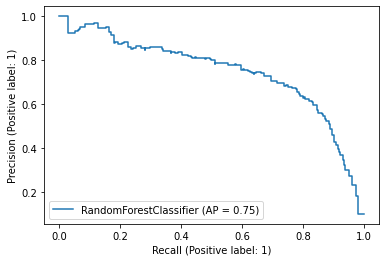

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score

plt.figure(figsize=(16,10))

disp = plot_precision_recall_curve(clf, test_feature_df, test_true_y)